<a href="https://colab.research.google.com/github/kkaung66/CS498_LHW2_Codes/blob/main/LHW2_Q2_and_Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ml-100k.zip  sample_data/


In [ ]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import torch
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt


In [ ]:
print("Downloading movielens data...")
from urllib.request import urlretrieve
import zipfile

urlretrieve ("https://github.com/aravindsankar28/Recommender-Models/blob/main/ml-100k.zip?raw=true", "ml-100k.zip")
zip_ref = zipfile.ZipFile('ml-100k.zip', "r")

zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))



Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


We first load the MovieLens Data, and create DataFrames containing movies, users, and ratings.


In [ ]:
# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    'ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')


In [ ]:
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')


In [ ]:
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]

movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols

movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

In [ ]:
# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = users["user_id"].apply(lambda x: int(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: int(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: int(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: int(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))


In [ ]:
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')
movielens = movielens.drop(columns = ["video_release_date", "imdb_url"])

In [ ]:
movielens.head()

,user_id,movie_id,rating,unix_timestamp,title,release_date,genre_unknown,Action,Adventure,Animation,...,Romance,Sci-Fi,Thriller,War,Western,year,age,sex,occupation,zip_code
0,195,241,3.0,881250949,Kolya (1996),24-Jan-1997,0,0,0,0,...,0,0,0,0,0,1997,49,M,writer,55105
1,195,256,2.0,881251577,Men in Black (1997),04-Jul-1997,0,1,1,0,...,0,1,0,0,0,1997,49,M,writer,55105
2,195,110,4.0,881251793,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,0,0,0,0,...,1,0,0,0,0,1996,49,M,writer,55105
3,195,24,4.0,881251955,"Birdcage, The (1996)",08-Mar-1996,0,0,0,0,...,0,0,0,0,0,1996,49,M,writer,55105
4,195,381,4.0,881251843,"Adventures of Priscilla, Queen of the Desert, ...",01-Jan-1994,0,0,0,0,...,0,0,0,0,0,1994,49,M,writer,55105


In [ ]:
def flatten_cols(df):
    df.columns = [' '.join(col).strip() for col in df.columns.values]
    return df

pd.DataFrame.flatten_cols = flatten_cols

users_ratings = (
    ratings
    .groupby('user_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols()
    .merge(users, on='user_id')
)


### Question 1: Rating Distribution of users.
First, we look at the distribution of ratings per user to examine number of ratings and average rating per user.

Plot two histograms depicting: (a) the number of ratings per user and (b) average rating per user. (Use plt.hist with 10 bins)

What do you observe?



### Question 2: Rating Distribution of movies.

Similarly, plot the rating distribution of each movie with respect to (a) the number of ratings per movie and (b) average rating per movie.


In [ ]:
# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.3):
    '''Splits a DataFrame into training and test sets.
    Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
    Returns:
    train_df: dataframe for training
    test_df: dataframe for testing
    '''
    eval_df = df.sample(frac=holdout_fraction, replace=False)
    
    val_df = eval_df.sample(frac=(1/3.0), replace=False)    
    test_df = eval_df[~eval_df.index.isin(val_df.index)]
    
    train_df = df[~df.index.isin(eval_df.index)]
    return train_df, val_df, test_df


In [ ]:
# train, val, test = split_dataframe(movielens)


In [ ]:
# load train, val, test data for consistency.

train = pd.read_csv('ml-100k/train.csv')
val = pd.read_csv('ml-100k/val.csv')
test = pd.read_csv('ml-100k/test.csv')

### Item Neighborhood-based Collaborative Filtering

The code described in the next cell provides an initial implementation of neighborhood-based CF using item-based nearest neighbors. 

In [ ]:
class NeighborhoodCF():

    def __init__(self, train):
        self.mu = train['rating'].mean()
        self.rating_matrix = sp.csr_matrix((train['rating'], (train['user_id'], train['movie_id']))).toarray()
        n_users, n_items = self.rating_matrix.shape[0], self.rating_matrix.shape[1]
        self.n_users, self.n_items = n_users, n_items
        
        # Compute item biases.
        self.item_bias, self.user_bias = np.zeros(n_items), np.zeros(n_users)
                
        item_bias_dict = dict(train.sort_values(['movie_id'],ascending=True).
                              groupby(['movie_id'])['rating'].apply(lambda x: sum(x)/len(x) - self.mu))
        
        for key, val in item_bias_dict.items():
            self.item_bias[key] = val

        # Compute user biases.
        user_bias_dict = train.sort_values(['user_id'],ascending=True).groupby(['user_id']).apply(self.get_user_bias)

        for key, val in user_bias_dict.items():
            self.user_bias[key] = val
        
        # Compute a dictionary to store list of items per user (and vice-versa).
        self.user_items_dict = defaultdict(lambda: [], dict(train.groupby('user_id')['movie_id'].apply(list)))
        self.item_users_dict = defaultdict(lambda: [], dict(train.groupby('movie_id')['user_id'].apply(list)))                
        
        # Compute movie-movie similarities based on genres.
        
        movie_genres = train[['movie_id'] + genre_cols].drop_duplicates().sort_values('movie_id')
        movie_genres['genre'] = movie_genres[genre_cols].values.tolist()
        movie_genres_dict = dict(movie_genres[['movie_id', 'genre']].values)

        self.movie_genres_matrix = np.zeros([n_items, len(genre_cols)])

        for key, val in movie_genres_dict.items():
            self.movie_genres_matrix[key] = val
            
        self.movie_similarity = cosine_similarity(self.movie_genres_matrix)
        self.pearson = np.zeros([n_items, n_items])
        #print(self.rating_matrix)
    ###
    ###
    ###
    def get_pearson_correlation(self, movie_id_1, movie_id_2, bias = True):
        movie_1_dict = self.item_users_dict[movie_id_1]
        movie_2_dict = self.item_users_dict[movie_id_2]
        similar_users_id = set(movie_1_dict).intersection(set(movie_2_dict))
        if len(similar_users_id) == 0:
            return 0
        numerator = 0
        denumerator = 0
        for users in similar_users_id:
            if bias == True:
                b_ui = self.mu + self.user_bias[users] + self.item_bias[movie_id_1]
                b_uj = self.mu + self.user_bias[users] + self.item_bias[movie_id_2]
            else:
                b_ui = 0
                b_uj = 0
            numerator += (self.rating_matrix[users][movie_id_1] - b_ui) * (
                            self.rating_matrix[users][movie_id_2] - b_uj)
            denumerator += ((self.rating_matrix[users][movie_id_1] - b_ui) ** 2) * ((
                            self.rating_matrix[users][movie_id_2] - b_uj) ** 2)
        return numerator / np.sqrt(denumerator)
    ####
    ####
    ####
        
    def get_user_bias(self, group):    
        items = group['movie_id']
        ratings = group['rating']
        assert len(items) == len(ratings)
        result = 0.0

        for item, rating in zip(items, ratings):
            result += rating - self.item_bias[item] - self.mu

        result = result/len(items)
        return result
    


    #This function finds k similar items given the item_id (based on pearson correlation).
    def find_nearest_neighbors(self, item_id,  k=5, item_list=None, pearson = True, bias=True):
        if item_list is None:
            item_list = list(range(0, self.n_items))
        
        if pearson:
            similarities = np.array([self.get_pearson_correlation(item_id, j, bias = bias) for j in item_list])
        else:
            similarities = self.movie_similarity[item_id, item_list]
                
        similar_items_indices = similarities.argsort()[::-1][:k]
        return [item_list[idx] for idx in similar_items_indices]
    
    def knn_predict(self, user, item, k=5, pearson = True, bias = True):
        numerator, denominator = 0.0, 0.0
        neighbor_items = self.user_items_dict[user]
        assert k >=0
        neighbor_items = self.find_nearest_neighbors(item, k, neighbor_items, pearson, bias = bias)
        
        for j in neighbor_items:
            sij = self.movie_similarity[item, j] + 0.000001
            denominator += sij         
            numerator += sij * (self.rating_matrix[user][j])
                
        rui = (numerator / denominator)
        return rui
                


    # TODO: complete this function in question 4    
    def bias_predict(self, user, item):
        pass
    
    # TODO: complete this function in question 5
    def knn_bias_predict(self, user, item, k=5):
        pass
    


In [ ]:
model_CF = NeighborhoodCF(train)
mse_ls = []
mse_ls_no_bias = []
for k in [1, 5, 10, 50, 100]:
    print(f"running k = {k}")
    preds, preds_no_bias, targets = [], [], []
    predsb = []
    for idx, row in enumerate(test[['user_id', 'movie_id', 'rating']].values):            
        u, i, r = tuple(row)
        pred = model_CF.knn_predict(int(u), int(i), k)
        pred = np.clip(pred, 0, 5)
        preds.append(pred)

        pred_no_bias = model_CF.knn_predict(int(u), int(i), k, pearson = True, bias = False)
        pred_no_bias = np.clip(pred_no_bias, 0, 5)
        preds_no_bias.append(pred_no_bias)
        targets.append(r)

    mse_ls.append(torch.nn.MSELoss()(torch.tensor(preds), torch.tensor(targets)))
    mse_ls_no_bias.append(torch.nn.MSELoss()(torch.tensor(preds_no_bias), torch.tensor(targets)))
    #mse_ls_b.append(torch.nn.MSELoss()(torch.tensor(predsb), torch.tensor(targets)))

running k = 1
running k = 5
running k = 10
running k = 50
running k = 100


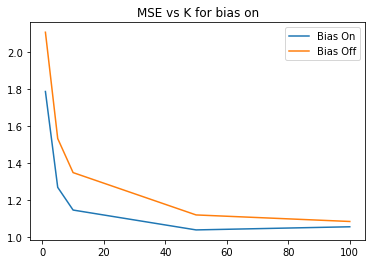

In [37]:
k_list = [1, 5, 10, 50, 100]
plt.plot(k_list, mse_ls, label = 'Bias On')
plt.plot(k_list, mse_ls_no_bias, label = 'Bias Off')
plt.title("MSE vs K for bias on")
plt.legend()
plt.plot()
plt.show()

### Question 3: Neighborhood-based CF (impact of neighborhood size)

Run the above neighborhood-based recommender `knn_predict` for different neighborhood sizes $K = \{1, 5, 10, 50, 100\}$ and plot the variation in test MSE error with respect to $K$. 


### Question 4: Bias recommender baseline. 

Complete the `bias_predict` function within the `NeighborhoodCF` class to implement the baseline recommender using user-specific, item-specific and global bias factors. $ r_{ui} = b_u + b_i + \mu $.

How does the performance of bias prediction baseline compare with the nearest neighbor recommender in `knn_predict` ? Explain.


### Question 5: Neighborhood-based CF with bias


Complete the `knn_bias_predict` function within the `NeighborhoodCF` class to implement the nearest neighborhood  recommender using user-specific, item-specific and global bias factors. (Extend `knn_predict` with biases)

$$\hat{r}_{u,i} = b_{u,i}+ \frac{\sum_{j \in S^k(i;u)} s_{i,j} \times (r_{u,j} - b_{u,j}) }{\sum_{j \in S^k(i;u)} s_{i,j}} $$


$$ b_{u,i} =  \mu + b_u + b_i$$


How does the performance of `knn_bias_predict` compare with `knn_predict` and `bias_predict` ? Explain.

### Matrix Factorization based Collaborative Filtering

This is an implementation of Matrix Factorization using a machine learning framework PyTorch - https://pytorch.org/ with automatic gradient computation.

Instead of SGD, we use PyTorch due to better optimizers and batch-wise efficient computations.  

Unlike the neighborhood-based CF model which is non-parametric, the MF model has multiple learnable parameters (latent factors) and hyper-parameters (learning rate, number of latent factors, batch size, etc.). 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=20, bias=False):
        super().__init__()
        # create user embeddings
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.bias = bias
        
        # create item embeddings
        self.item_factors = torch.nn.Embedding(n_items, n_factors)
        if self.bias:
            self.user_bias = torch.nn.Embedding(n_users, 1)
            self.item_bias = torch.nn.Embedding(n_items, 1)
            
            self.user_bias.weight.data.fill_(0.)
            self.user_bias.weight.data.fill_(0.)
        
        torch.nn.init.xavier_uniform_(self.user_factors.weight)
        torch.nn.init.xavier_uniform_(self.item_factors.weight)
        
    def forward(self, user, item):
        # matrix multiplication
        if self.bias:
            return self.user_bias(user).squeeze(-1) + self.item_bias(item).squeeze(-1) + \
                (self.user_factors(user)*self.item_factors(item)).sum(-1)
        else:
            return (self.user_factors(user)*self.item_factors(item)).sum(-1)

    def predict(self, user, item):
        return self.forward(user, item)
    

In [ ]:
# hyper-parameters.

lr = 1e-3
batch_size = 1024
n_factors = 128

model_MF = MatrixFactorization(model_CF.n_users, model_CF.n_items, n_factors=n_factors, bias=False)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_MF.parameters(), lr=lr, weight_decay=1e-4)

train_ratings = train[['user_id', 'movie_id', 'rating']].values
test_ratings = test[['user_id', 'movie_id', 'rating']].values
val_ratings = val[['user_id', 'movie_id', 'rating']].values

def test_model(model_MF, test_ratings):
    n_batches = len(test_ratings) // batch_size
    preds, targets = [], []
    for b in range(n_batches):
        batch_data = test_ratings[(b* batch_size) : (b+1)* batch_size]        
        batch_users, batch_items, batch_ratings = batch_data[:, 0], batch_data[:, 1], batch_data[:, 2]
        user, item = torch.LongTensor(batch_users), torch.LongTensor(batch_items)
        pred = model_MF.predict(user, item).detach()
        pred = np.clip(pred, 0, 5)
        preds.append(pred)
        targets.append(batch_ratings)
    preds, targets = np.concatenate(preds), np.concatenate(targets)
    test_loss = loss_fn(torch.tensor(preds), torch.tensor(targets)).item()
    # print ("test loss: ", test_loss)
    return test_loss

def val_model(model_MF, val_ratings):
    n_batches = len(test_ratings) // batch_size
    preds, targets = [], []
    for b in range(n_batches):
        batch_data = test_ratings[(b* batch_size) : (b+1)* batch_size]        
        batch_users, batch_items, batch_ratings = batch_data[:, 0], batch_data[:, 1], batch_data[:, 2]
        user, item = torch.LongTensor(batch_users), torch.LongTensor(batch_items)
        pred = model_MF.predict(user, item).detach()
        pred = np.clip(pred, 0, 5)
        preds.append(pred)
        targets.append(batch_ratings)
    preds, targets = np.concatenate(preds), np.concatenate(targets)
    test_loss = loss_fn(torch.tensor(preds), torch.tensor(targets)).item()
    # print ("Val loss: ", test_loss)
    return test_loss
    
test_loss_list = []
train_loss_list = []
val_loss_list= []
epoch_vals = []

for epoch in range(0, 150):
    train_loss = 0.0
    n_batches = len(train_ratings) // batch_size
    if train_ratings % batch_size is not 0:
        n_batches += 1
    np.random.shuffle(train_ratings)
    for b in range(n_batches):
        batch_data = train_ratings[(b* batch_size) : (b+1)* batch_size]
        # get user, item and rating data
        batch_users, batch_items, batch_ratings = batch_data[:, 0], batch_data[:, 1], batch_data[:, 2]
        user, item = torch.LongTensor(batch_users), torch.LongTensor(batch_items)
        rating = torch.FloatTensor(batch_ratings)
        optimizer.zero_grad()
        model_MF.zero_grad()
        
        # predict
        prediction = model_MF(user, item)
        loss = loss_fn(prediction, rating)

        # backpropagate
        loss.backward()

        # update weights
        optimizer.step()
        
        train_loss += loss.item()
        
        
    # print ("epoch {}: train loss {}".format(epoch, train_loss/n_batches))
    test_loss_list.append(test_model(model_MF, test_ratings))   
    train_loss_list.append(train_loss/n_batches)
    val_loss_list.append(val_model(model_MF, val_ratings))
    epoch_vals.append(epoch)


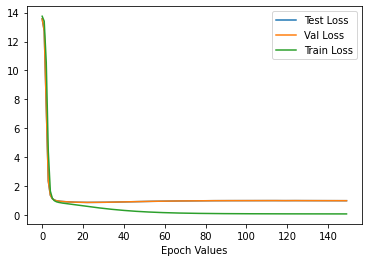

In [ ]:
#plot for Q3.1
plt.plot(epoch_vals, test_loss_list, label = 'Test Loss')
plt.plot(epoch_vals, val_loss_list, label = 'Val Loss')
plt.plot(epoch_vals, train_loss_list, label = 'Train Loss')
plt.xlabel("Epoch Values")
plt.legend()
plt.plot()
plt.show()

In [ ]:
# hyper-parameters.

lr = 1e-3
batch_size = 1024
n_factors_list = [4,16,64,128]

model_MF = MatrixFactorization(model_CF.n_users, model_CF.n_items, n_factors=n_factors, bias=False)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_MF.parameters(), lr=lr, weight_decay=1e-4)

train_ratings = train[['user_id', 'movie_id', 'rating']].values
test_ratings = test[['user_id', 'movie_id', 'rating']].values
val_ratings = val[['user_id', 'movie_id', 'rating']].values

def test_model(model_MF, test_ratings):
    n_batches = len(test_ratings) // batch_size
    preds, targets = [], []
    for b in range(n_batches):
        batch_data = test_ratings[(b* batch_size) : (b+1)* batch_size]        
        batch_users, batch_items, batch_ratings = batch_data[:, 0], batch_data[:, 1], batch_data[:, 2]
        user, item = torch.LongTensor(batch_users), torch.LongTensor(batch_items)
        pred = model_MF.predict(user, item).detach()
        pred = np.clip(pred, 0, 5)
        preds.append(pred)
        targets.append(batch_ratings)
    preds, targets = np.concatenate(preds), np.concatenate(targets)
    test_loss = loss_fn(torch.tensor(preds), torch.tensor(targets)).item()
    return test_loss
mean_square_error = {}
mse_minimum_values = []
for n_factors in n_factors_list:
    mean_square_error[n_factors] = []
    for epoch in range(0, 150):
        train_loss = 0.0
        n_batches = len(train_ratings) // batch_size
        if train_ratings % batch_size is not 0:
            n_batches += 1
        np.random.shuffle(train_ratings)
        for b in range(n_batches):
            batch_data = train_ratings[(b* batch_size) : (b+1)* batch_size]
            # get user, item and rating data
            batch_users, batch_items, batch_ratings = batch_data[:, 0], batch_data[:, 1], batch_data[:, 2]
            user, item = torch.LongTensor(batch_users), torch.LongTensor(batch_items)
            rating = torch.FloatTensor(batch_ratings)
            optimizer.zero_grad()
            model_MF.zero_grad()
            
            # predict
            prediction = model_MF(user, item)
            loss = loss_fn(prediction, rating)

            # backpropagate
            loss.backward()

            # update weights
            optimizer.step()
            
            train_loss += loss.item()
        mean_square_error[n_factors].append(train_loss)
    mse_minimum_values.append(train_loss)
        

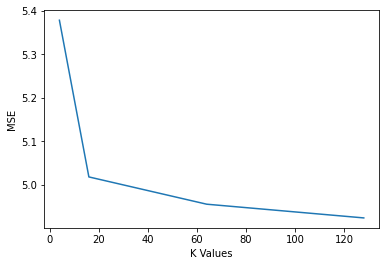

In [ ]:
#plot for Q3.2

plt.plot(n_factors_list, mse_minimum_values)
plt.xlabel("K Values")
plt.ylabel("MSE")
plt.plot()
plt.show()

In [ ]:
batch_sizes = [16, 128, 1024]
learning_rates = [1e-4, 1e-3, 1e-2]
n_factors = 128
result = {}

for batch_size in batch_sizes:
    result[batch_size] = 0
    for learning_rate in learning_rates:
        
        model_MF = MatrixFactorization(model_CF.n_users, model_CF.n_items, n_factors=n_factors, bias=False)

        loss_fn = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model_MF.parameters(), lr=lr, weight_decay=1e-4)

        train_ratings = train[['user_id', 'movie_id', 'rating']].values
        val_ratings = val[['user_id', 'movie_id', 'rating']].values
        test_ratings = test[['user_id', 'movie_id', 'rating']].values

        prev_mse = 10000
        for epoch in range(0, 150):
            train_loss = 0.0
            n_batches = len(train_ratings) // batch_size
            if train_ratings % batch_size is not 0:
                n_batches += 1
            np.random.shuffle(train_ratings)
            for b in range(n_batches):
                batch_data = train_ratings[(b* batch_size) : (b+1)* batch_size]
                # get user, item and rating data
                batch_users, batch_items, batch_ratings = batch_data[:, 0], batch_data[:, 1], batch_data[:, 2]
                user, item = torch.LongTensor(batch_users), torch.LongTensor(batch_items)
                rating = torch.FloatTensor(batch_ratings)
                optimizer.zero_grad()
                model_MF.zero_grad()
                
                # predict
                prediction = model_MF(user, item)
                loss = loss_fn(prediction, rating)

                # backpropagate
                loss.backward()

                # update weights
                optimizer.step()
                
                train_loss += loss.item()
                
            val_mse = val_model(model_MF, val_ratings)
            print ("epoch {}: val loss {}".format(epoch, val_mse))
            if val_mse > prev_mse:
                result.append(test_model(model_MF, test_ratings))
                break
            else:
                prev_mse = val_mse

            if epoch == 149:
                result.append(test_model(model_MF, test_ratings))
print(result)

epoch 0: train loss 1.126954488805849
epoch 1: train loss 1.006101476954654
epoch 2: train loss 0.9796180258300065
epoch 3: train loss 0.9668979152019248
epoch 4: train loss 0.9591201192309414
epoch 5: train loss 0.9578274189009337
epoch 6: train loss 0.9793128737957042
epoch 0: train loss 1.1147793062657585
epoch 1: train loss 1.0179714972185954
epoch 2: train loss 0.9759155412908541
epoch 3: train loss 0.9768712645530581
epoch 0: train loss 1.1140323890992676
epoch 1: train loss 1.0258812967201305
epoch 2: train loss 0.9794300782999353
epoch 3: train loss 0.973083052724944
epoch 4: train loss 0.9686067593363962
epoch 5: train loss 0.9595715109712566
epoch 6: train loss 0.9699649230195824
epoch 0: train loss 4.511581109704279
epoch 1: train loss 1.148381340952426
epoch 2: train loss 0.9901020171186631
epoch 3: train loss 0.9536061956513103
epoch 4: train loss 0.9258624561825732
epoch 5: train loss 0.9078184678693634
epoch 6: train loss 0.897668810663738
epoch 7: train loss 0.887433157